In [1]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io, os, re
from scipy.io import matlab
from datetime import datetime
from Mouse_Data import Mouse_Data
from helpers import *
from visualization import *
pd.options.mode.chained_assignment = None  # default='warn'
matplotlib.rcParams.update({'font.size':18, 'font.family':'Times New Roman', 
                            'axes.facecolor':'white' , 'figure.facecolor':'white', 'figure.dpi':200})   

# Notes on current animals:
# Below animals were done with broken manipulator (no up movement)
# SNA-123598: Some crashes with saline injection learned on day 5
# SNA-123599: Succesful saline injections and good performance
# SNA-123601: Note says this is the crashed session, Saline injection Maybe use sice it did learn?
# SNA-123602: Crashes and failed anisomycin injections

# First batch with rapamycin, sessions 1 with shady injector
# SNA-123995: Rapamycin injections, good experiments
# SNA-123996: Rapamycin, some issues, but succesful injection

# Second batch 
# SNA-126687: Shitty cranio, saline injections
# SNA-126688: PBS, little issues
# SNA-123690: Rapamycin, little issues OLD RAPA

# Third
# SNA-127100: Session two the first 50 trials are corrupted... Saline
# SNA-127101: rAPA
# SNA-127102:RAPA

root = 'D:/mStim_data/PSI/'
path_ext = '/microstim/Session Data/'

ctrl_IDs = ['SNA-123599', 'SNA-126687', 'SNA-126688', 'SNA-127100']
exp_IDs = ['SNA-123995','SNA-123996', 'SNA-127101', 'SNA-127102'] # In this case it refers to 200 nL superficial rapamycin injection

ctrl_data = []
for ID in ctrl_IDs:
    mouse = Mouse_Data(root+ID+path_ext)
    ctrl_data.append(mouse)
    # plot_raster_rt(mouse)
    # plot_performance(mouse)
    # plot_trialPerformance(mouse)
    # plot_lickPerformance(mouse)

    

exp_data = []
for ID in exp_IDs:
    mouse = Mouse_Data(root+ID+path_ext)
    exp_data.append(mouse)
    # plot_raster_rt(mouse)
    # plot_performance(mouse)
    # plot_trialPerformance(mouse)
    # plot_lickPerformance(mouse)

    

Data will be concatenated; please check validity.


C:\Users\miksc\AppData\Local\Temp\ipykernel_5708\1693333346.py:248: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(savePath + 'Fig2.svg')
C:\Users\miksc\AppData\Local\Temp\ipykernel_5708\1693333346.py:249: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(savePath + 'Fig2.pdf')
C:\Users\miksc\AppData\Local\Temp\ipykernel_5708\1693333346.py:250: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(savePath + 'Fig2.png')
c:\Users\miksc\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


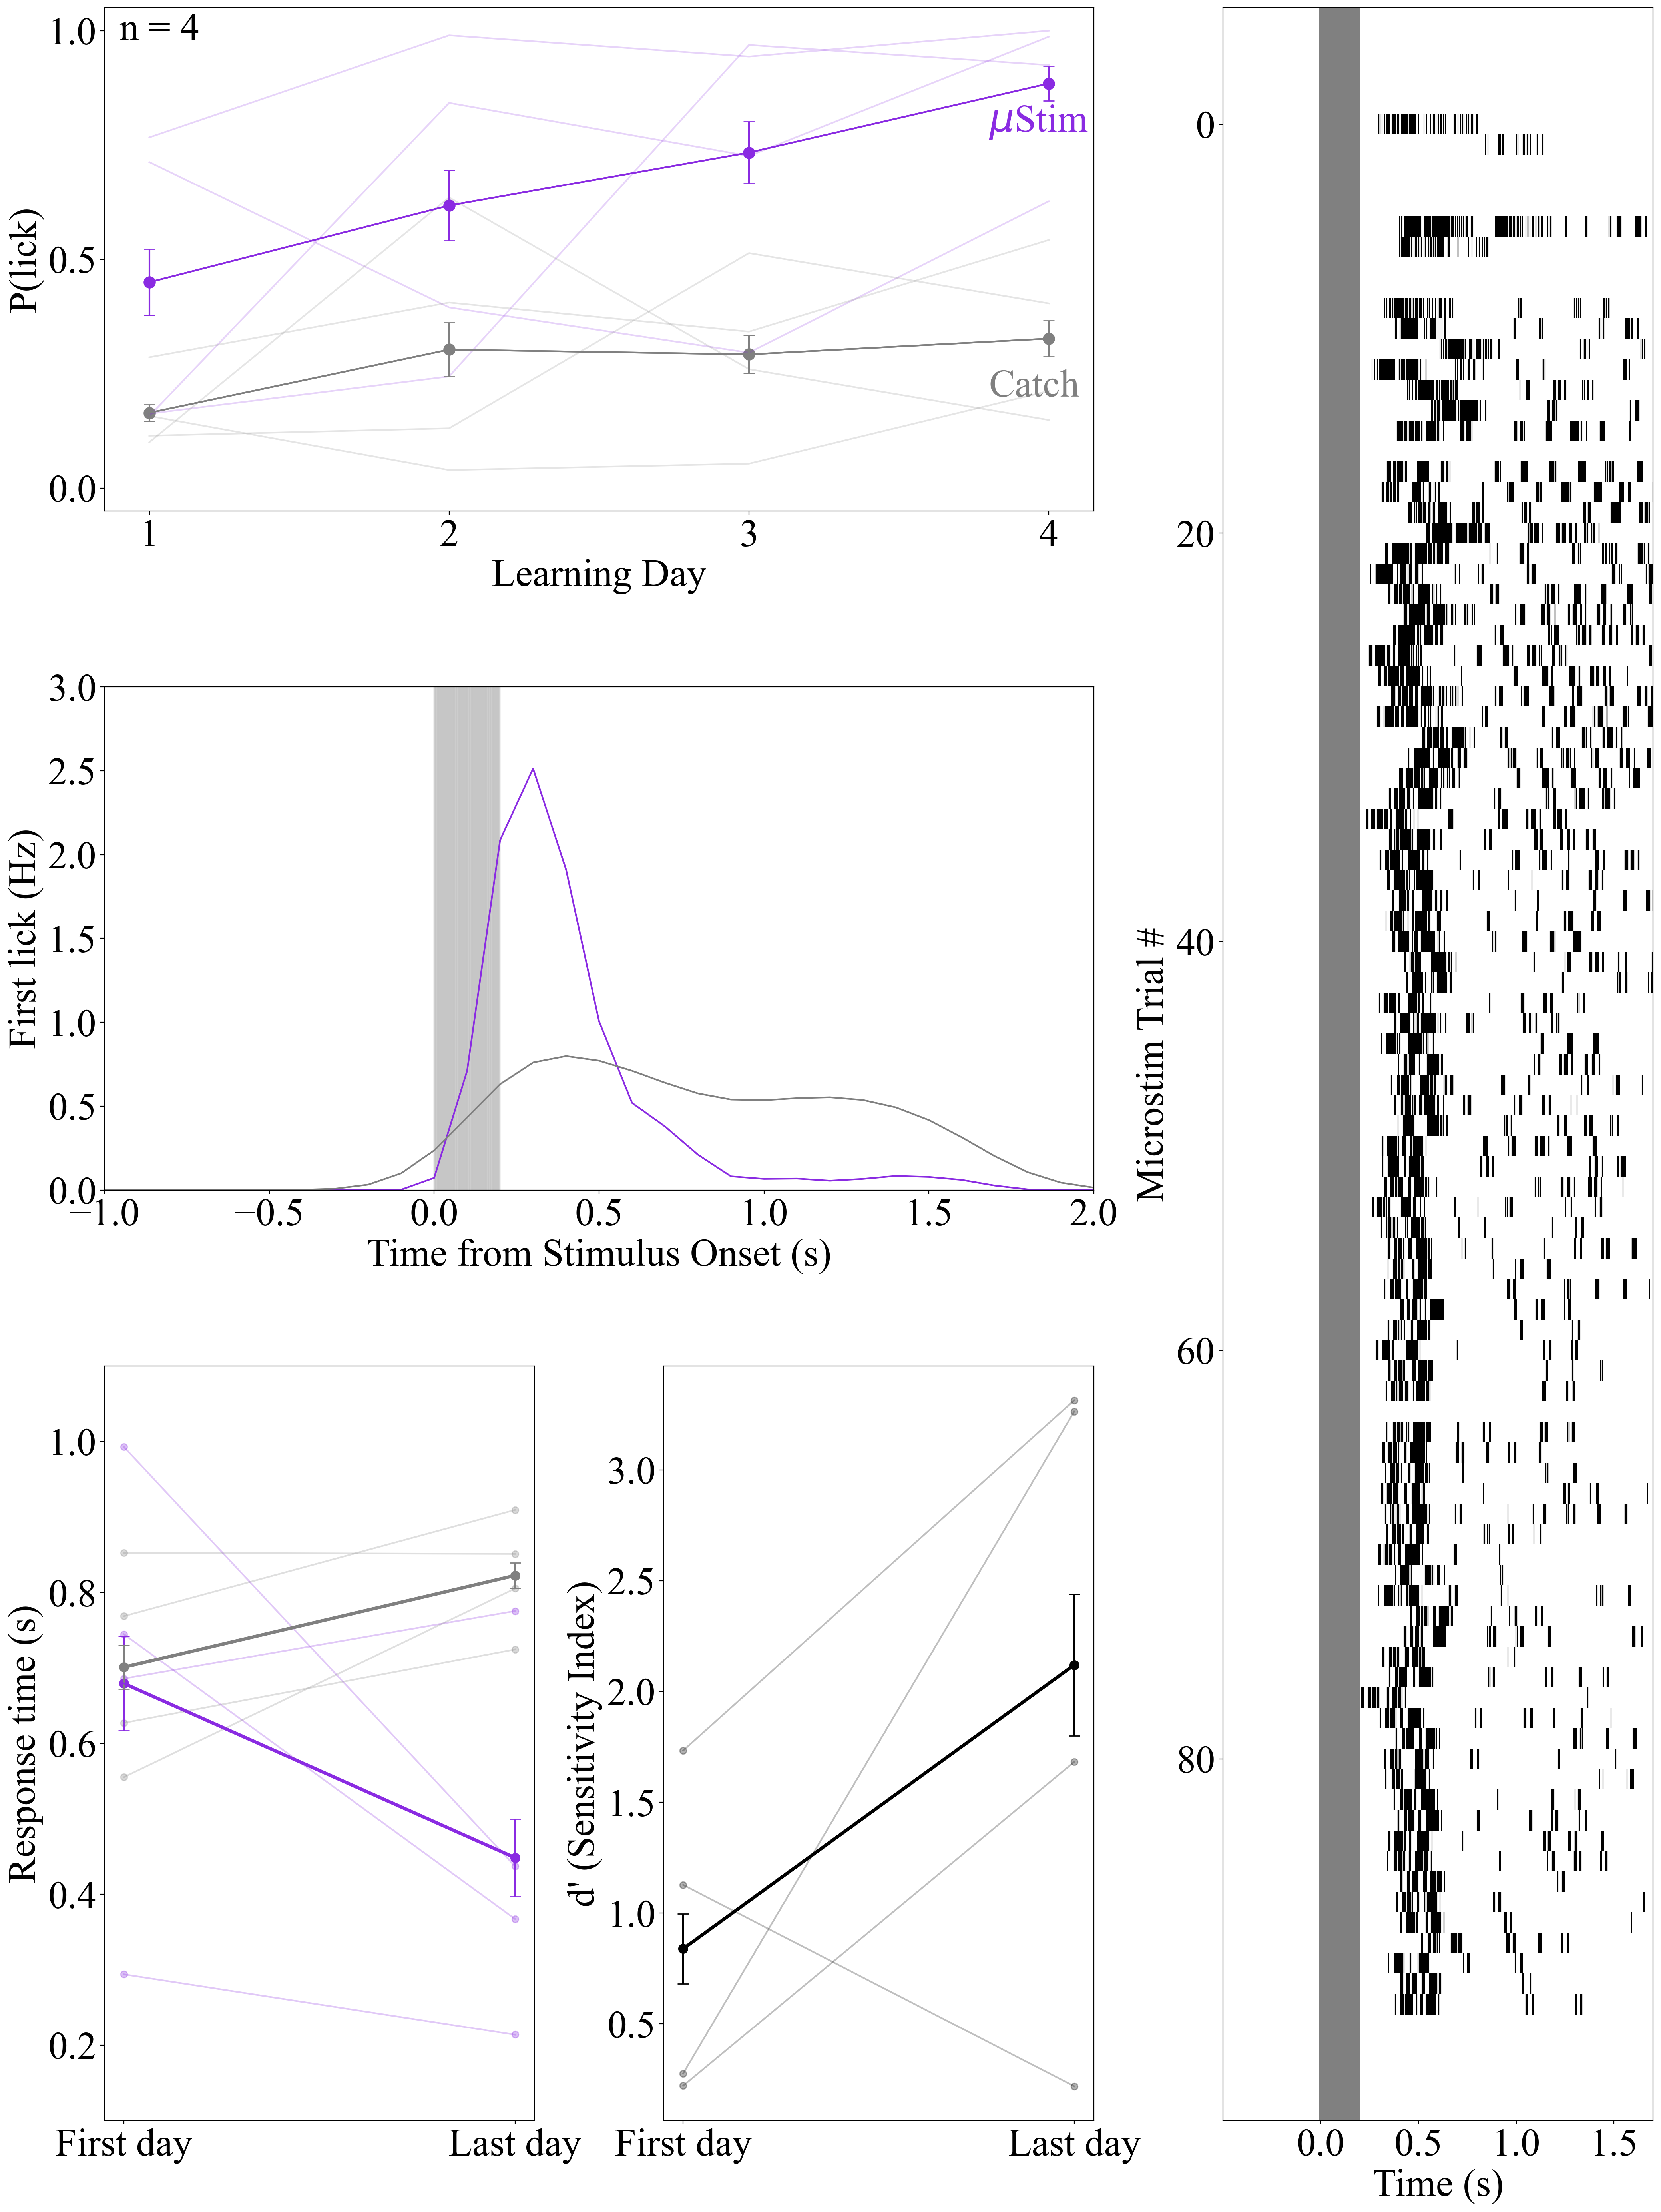

In [53]:
''' Creating a big figure of the behaviour during the microstimulation task with the following graphs
Top left: PLick                                       Top & middle right: raster licks
Middle left: f First Lick
Bottom left: RT sessions                              Bottom right: D' sessions
'''
from matplotlib.gridspec import GridSpec
matplotlib.rcParams.update({'font.size':35, 'font.family':'Times New Roman', 'axes.facecolor':'white', 'figure.dpi':200})   
fig = plt.figure(figsize=(25, 35), tight_layout=True)
fig.patch.set_facecolor('white')
gs0 = GridSpec(3, 3, height_ratios=[1,1,1.5], wspace=0.3, hspace=0.3) # 
# gs1 = GridSpec(1, 2, wspace=0.1)
# gs1 = GridSpec(2, 1, wspace=0.1)
topleft = fig.add_subplot(gs0[0,:-1])
midleft = fig.add_subplot(gs0[1,:-1])
right = fig.add_subplot(gs0[0:,-1])
botleft = fig.add_subplot(gs0[2:,0])
botmid = fig.add_subplot(gs0[2:,1])

'''TOPLEFT: PLICK PLOT'''
# For all animals get PLick
mstimP_all = []
catchP_all = []
for mouse in ctrl_data:
    mstimP, catchP = get_PLick(mouse)
    mstimP_all.append(mstimP)
    catchP_all.append(catchP)
# Visualize
[topleft.plot(mstimP, color='blueviolet', alpha=0.2) for mstimP in mstimP_all]
[topleft.plot(catchP, color='gray', alpha=0.2) for catchP in catchP_all]
# Calculate average and sem for each session's Plick
# mStim
avg_list, std_list = get_avg_std_threshold(mstimP_all, max_sessions=4)
sem_list = [std/len(ctrl_data) for std in std_list]
topleft.plot(avg_list, color='blueviolet')
topleft.scatter(x=[0,1,2,3], y=avg_list, color='blueviolet', linewidths=5)
# Add SEM
x = np.arange(0, len(avg_list), 1)
topleft.errorbar(x, avg_list, yerr=sem_list, c='blueviolet', capsize=5)
# Catch
avg_list, std_list = get_avg_std_threshold(catchP_all, max_sessions=4)
sem_list = [std/len(ctrl_data) for std in std_list]
topleft.plot(avg_list, color='gray')
topleft.scatter(x=[0,1,2,3], y=avg_list, color='gray', linewidths=5)
# Add SEM
x = np.arange(0, len(avg_list), 1)
topleft.errorbar(x, avg_list, yerr=sem_list, c='gray',capsize=5)

topleft.set_xticks(x, [1,2,3,4])
topleft.set_xlabel('Learning Day')
topleft.set_ylim([-0.05, 1.05])
topleft.set_ylabel('P(lick)')
topleft.set_yticks([0, 0.5, 1])
topleft.text(2.8, 0.78, r'$\mu$Stim', c='blueviolet')
topleft.text(2.8, 0.20, 'Catch', c='gray')
topleft.text(-0.1, 0.98, 'n = 4')

'''MIDLEFT: F FIRSTLICK'''
# Calculate and plot the RT during a mStim trial TODO Histogram should be the average occurance of all mice
import scipy.stats as stats
RTs_mstim = []
RTs_catch = []
for mouse in ctrl_data:
    session = mouse.sessions[-1]
    session_data = mouse.session_data[session]

    # Differentiate between mStim and catch trials
    mstim = select_trialType(session_data, 'test')
    catch = select_trialType(session_data, 'catch')

    # Now select the hit trials
    mstim = mstim.loc[mstim['success'] == True]
    catch = catch.loc[catch['success'] == True]

    # Now plot a histogram of the first session response times
    RTs_mstim.append(mstim['response_t'])
    RTs_catch.append(catch['response_t'])
# Concat into full dataframe
RTs_mstim = pd.concat(RTs_mstim)
RTs_catch =pd.concat(RTs_catch)
x = np.arange(-1, len(avg_list), 0.1)
# Plot as line NOTE: the line is so high for the 0.2-0.25 ms probably because the animal started licking during the stimulus
[midleft.axvline(i, -1, 3, c='gray', alpha=0.1) for i in np.arange(0, 0.2, 0.001)]
# mStim
density = stats.gaussian_kde(RTs_mstim)
midleft.plot(x, density(x), c='blueviolet')
# catch
density = stats.gaussian_kde(RTs_catch)
midleft.plot(x, density(x), c='gray')

midleft.set_xlim([-1,2])
midleft.set_ylim(0, 3)
midleft.set_xlabel('Time from Stimulus Onset (s)')
midleft.set_ylabel('First lick (Hz)')

'''RIGHT: Lick during last session mstim trials'''
'''docstring'''
mouse_data = ctrl_data[3]
# Check for peaking allowing the user to only see the plots of the first 2 sessions

n_sessions = len(mouse_data.sessions)

# Create legend patches 
gray_patch = matplotlib.patches.Patch(color='gray', label='Stimulus')

# Get and plot data for every session
for idx, session in enumerate(mouse_data.sessions):



    if idx != 3:
        continue

    # Only stimulation trails are necessary to plot here
    stimTrials = select_trialType(mouse_data.session_data[session], trialType=1)
    # stimTrials = mouse_data.session_data[session]

    # Get the licks, remove premature licks and zero on stim_t
    for i, trialData in enumerate(stimTrials.iterrows()):
        trialData = trialData[1] # Because the first value is the trialNumber, so slice
        curatedLicks = trialData['licks'] - trialData['stim_t']
        # curatedLicks = curateLicks(trialData)

        # Now add these licks to the rasterplot
        right.eventplot(curatedLicks, lineoffsets=i, colors='black', linewidths=0.75)
        [right.axvline(i, c='gray') for i in np.arange(0, 0.2, 0.005)]
        right.invert_yaxis()
        right.set_xlim([-0.5, 1.7])
        right.set_ylabel('Microstim Trial #')
        right.set_xlabel('Time (s)')
        # axs[idx].set_title(str(session))
        right.set_xticks(np.arange(0, 1.8, 0.5))

'''BOTTOMLEFT: Response time over sessions'''
# Improvement in response time during session start and session end
RT_dict = {'first_mStim':[], 'last_mStim':[], 'first_catch':[], 'last_catch':[]}
for mouse in ctrl_data:
    # Select the first and last session
    first_session = mouse.session_data[mouse.sessions[0]]
    last_session = mouse.session_data[mouse.sessions[-1]]

    # From the session get all the mStim hit trials 
    mStim_first = select_trialType(first_session, 'test')
    mStim_first = mStim_first.loc[mStim_first['success'] == True]
    # get the animals average RT
    rt_first = np.average(mStim_first['response_t'])
    RT_dict['first_mStim'].append(rt_first)
    # And the last sesh
    mStim_last = select_trialType(last_session, 'test')
    mStim_last = mStim_last.loc[mStim_last['success'] == True]
    RT_dict['last_mStim'].append(np.average(mStim_last['response_t']))

    # Catch
    # From the session get all the catch hit trials 
    catch_first = select_trialType(first_session, 'catch')
    catch_first = catch_first.loc[catch_first['success'] == True]

    # get the animals average RT
    rt_first = np.average(catch_first['response_t'])
    RT_dict['first_catch'].append(rt_first)

    # And the last sesh
    catch_last = select_trialType(last_session, 'catch')
    catch_last = catch_last.loc[catch_last['success'] == True]
    RT_dict['last_catch'].append(np.average(catch_last['response_t']))

# Ploterino
# mStim
# Individual lines and points
[botleft.plot([first, last], c='blueviolet', alpha=0.25) for first, last in zip(RT_dict['first_mStim'], RT_dict['last_mStim'])]    
[botleft.scatter(x=[0,1],y=[first, last], c='blueviolet', alpha=0.3) for first, last in zip(RT_dict['first_mStim'], RT_dict['last_mStim'])]  
# Average
botleft.plot([np.average(RT_dict['first_mStim']), np.average(RT_dict['last_mStim'])], c='blueviolet', linewidth=3)
botleft.scatter(x=[0,1], y=[np.average(RT_dict['first_mStim']), np.average(RT_dict['last_mStim'])], c='blueviolet', linewidths=3)
# SEM
std_first = np.std(RT_dict['first_mStim'])
std_last = np.std(RT_dict['last_mStim'])
sem_first = std_first/len(RT_dict['first_mStim'])
sem_last = std_last/len(RT_dict['last_mStim'])
botleft.errorbar([0,1], [np.average(RT_dict['first_mStim']), np.average(RT_dict['last_mStim'])], yerr=[sem_first, sem_last], c='blueviolet',capsize=5)

# Catch
[botleft.plot([first, last], c='gray', alpha=0.25) for first, last in zip(RT_dict['first_catch'], RT_dict['last_catch'])]    
[botleft.scatter(x=[0,1],y=[first, last], c='gray', alpha=0.3) for first, last in zip(RT_dict['first_catch'], RT_dict['last_catch'])]  
# Average
botleft.plot([np.average(RT_dict['first_catch']), np.average(RT_dict['last_catch'])], c='gray', linewidth=3)
botleft.scatter(x=[0,1], y=[np.average(RT_dict['first_catch']), np.average(RT_dict['last_catch'])], c='gray', linewidths=3)
# SEM
std_first = np.std(RT_dict['first_catch'])
std_last = np.std(RT_dict['last_catch'])
sem_first = std_first/len(RT_dict['first_catch'])
sem_last = std_last/len(RT_dict['last_catch'])
botleft.errorbar([0,1], [np.average(RT_dict['first_catch']), np.average(RT_dict['last_catch'])], yerr=[sem_first, sem_last], c='gray',capsize=5)

# Format
botleft.set_xticks([0,1], ['First day', 'Last day'])
botleft.set_ylim([0.1, 1.1])
botleft.set_yticks([0.2,0.4,0.6,0.8,1])
botleft.set_ylabel('Response time (s)')

'''BOTTOMLEFT: D prime control firstlast'''
dp_first_list = []
dp_last_list = []
for mouse in ctrl_data:
    # Get P(lick) for catch and mStim trials for all sessions
    mStim_Plicks, catch_Plicks = get_PLick(mouse, catchInf=True)

    # Only select the first and the last session
    first_mStim = mStim_Plicks[0]
    last_mStim = mStim_Plicks[-1]
    first_catch = catch_Plicks[0]
    last_catch = catch_Plicks[-1]
    
    # Calculate the inverse of the cdf (ppf) of each P-value
    first_mStim_z = stats.norm.ppf(first_mStim)
    last_mStim_z = stats.norm.ppf(last_mStim)
    first_catch_z = stats.norm.ppf(first_catch)
    last_catch_z = stats.norm.ppf(last_catch)

    # Now calculate d' = |z(mStim hit) - z(catch hit)|
    # Is taking the abolute necessary
    d_prime_first = abs(first_mStim_z - first_catch_z)
    dp_first_list.append(d_prime_first)
    d_prime_last = abs(last_mStim_z - last_catch_z)
    dp_last_list.append(d_prime_last)

# Ploterino
# Individual lines and points
[botmid.plot([first, last], c='black', alpha=0.25) for first, last in zip(dp_first_list, dp_last_list)]    
[botmid.scatter(x=[0,1],y=[first, last], c='black', alpha=0.3) for first, last in zip(dp_first_list, dp_last_list)]  
# Average
botmid.plot([np.average(dp_first_list), np.average(dp_last_list)], c='black', linewidth=3)
botmid.scatter(x=[0,1], y=[np.average(dp_first_list), np.average(dp_last_list)], c='black', linewidths=3)

# SEM
std_first = np.std(dp_first_list)
std_last = np.std(dp_last_list)
sem_first = std_first/len(dp_first_list)
sem_last = std_last/len(dp_last_list)
botmid.errorbar([0,1], [np.average(dp_first_list), np.average(dp_last_list)], yerr=[sem_first, sem_last], c='black',capsize=5)

# Format
# botmid.ylim([-0.05,4])
botmid.set_ylabel('d\' (Sensitivity Index)')
botmid.set_xticks([0,1], ['First day', 'Last day'])

# SAVE
savePath = 'C:/Users/miksc/Desktop/Figures/'
fig.savefig(savePath + 'Fig2.svg')
fig.savefig(savePath + 'Fig2.pdf')
fig.savefig(savePath + 'Fig2.png')

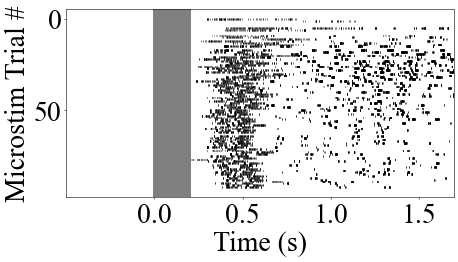